# Training Results — Q-Learning Pneumatic Teleoperation
10,000 episodes training run

In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.getcwd(), '..'))
os.chdir(os.path.join(os.getcwd(), '..'))

import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline

# Load training log
data = np.load('results/logs/training_log.npz')
ep_rewards = data['episode_rewards']
eval_rewards = data['eval_rewards']
eval_tracking = data['eval_tracking_rmse'] * 1000  # mm

import config as cfg
x_eval = np.arange(1, len(eval_rewards) + 1) * cfg.EVAL_EVERY

print(f'Episodes: {len(ep_rewards)}')
print(f'Eval checkpoints: {len(eval_rewards)}')
print(f'Final eval reward: {eval_rewards[-1]:.2f}')
print(f'Final tracking RMSE: {eval_tracking[-1]:.2f} mm')

Episodes: 10000
Eval checkpoints: 20
Final eval reward: -6.83
Final tracking RMSE: 8.17 mm


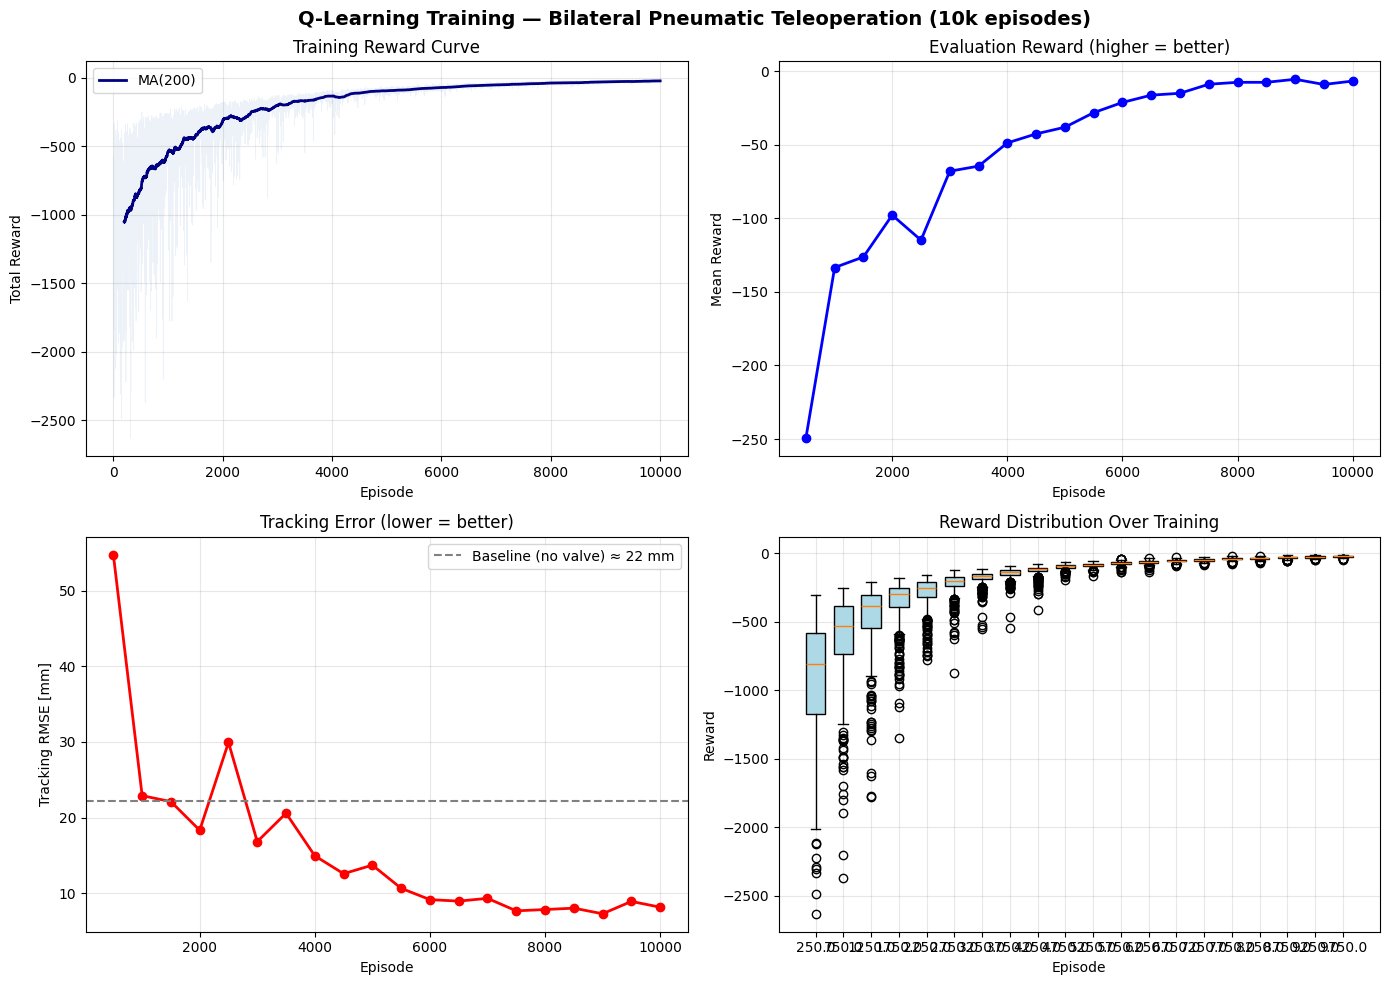

In [2]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Q-Learning Training — Bilateral Pneumatic Teleoperation (10k episodes)', fontsize=14, fontweight='bold')

# 1. Episode rewards with moving average
ax = axes[0, 0]
ax.plot(ep_rewards, alpha=0.1, lw=0.5, color='steelblue')
window = 200
ma = np.convolve(ep_rewards, np.ones(window)/window, mode='valid')
ax.plot(np.arange(window-1, len(ep_rewards)), ma, color='navy', lw=2, label=f'MA({window})')
ax.set_xlabel('Episode'); ax.set_ylabel('Total Reward')
ax.set_title('Training Reward Curve')
ax.legend(); ax.grid(True, alpha=0.3)

# 2. Eval mean reward
ax = axes[0, 1]
ax.plot(x_eval, eval_rewards, 'bo-', lw=2, markersize=6)
ax.set_xlabel('Episode'); ax.set_ylabel('Mean Reward')
ax.set_title('Evaluation Reward (higher = better)')
ax.grid(True, alpha=0.3)

# 3. Tracking RMSE
ax = axes[1, 0]
ax.plot(x_eval, eval_tracking, 'ro-', lw=2, markersize=6)
ax.axhline(22.2, color='gray', ls='--', lw=1.5, label='Baseline (no valve) ≈ 22 mm')
ax.set_xlabel('Episode'); ax.set_ylabel('Tracking RMSE [mm]')
ax.set_title('Tracking Error (lower = better)')
ax.legend(); ax.grid(True, alpha=0.3)

# 4. Reward distribution over time
ax = axes[1, 1]
chunks = np.array_split(ep_rewards, 20)
positions = np.linspace(250, 9750, 20)
bp = ax.boxplot([c for c in chunks], positions=positions, widths=350, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
ax.set_xlabel('Episode'); ax.set_ylabel('Reward')
ax.set_title('Reward Distribution Over Training')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/plots/training_overview.png', dpi=150, bbox_inches='tight')
plt.show()

In [3]:
# Run one RL episode and one baseline for comparison
from teleop_env import TeleopEnv
from q_learning_agent import QLearningAgent

env = TeleopEnv()
state_dims = env.get_state_dims()
agent = QLearningAgent(state_dims, cfg.N_ACTIONS)
agent.load('results/models/q_table.npy')
agent.epsilon = 0.0
print(agent)

# RL episode
obs, _ = env.reset()
state = env.discretise_obs(obs)
done = False
while not done:
    action = agent.select_action(state)
    obs, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    state = env.discretise_obs(obs)
h_rl = env.render()

# Baseline (zero voltage)
obs, _ = env.reset()
zero_act = int(np.argmin(np.abs(cfg.V_LEVELS)))
done = False
while not done:
    _, _, terminated, truncated, _ = env.step(zero_act)
    done = terminated or truncated
h_bl = env.render()

pe_rl = np.array(h_rl['pos_error']) * 1000
pe_bl = np.array(h_bl['pos_error']) * 1000
rmse_rl = np.sqrt(np.mean(pe_rl**2))
rmse_bl = np.sqrt(np.mean(pe_bl**2))

print(f'\nRL Tracking RMSE:       {rmse_rl:.2f} mm')
print(f'Baseline Tracking RMSE: {rmse_bl:.2f} mm')
print(f'Improvement:            {(1 - rmse_rl/rmse_bl)*100:.1f}%')

QLearningAgent(states=(10, 7, 7, 7), actions=9, Q-entries=30,870, ε=0.0000, coverage=0.0%)

RL Tracking RMSE:       8.17 mm
Baseline Tracking RMSE: 14.36 mm
Improvement:            43.1%


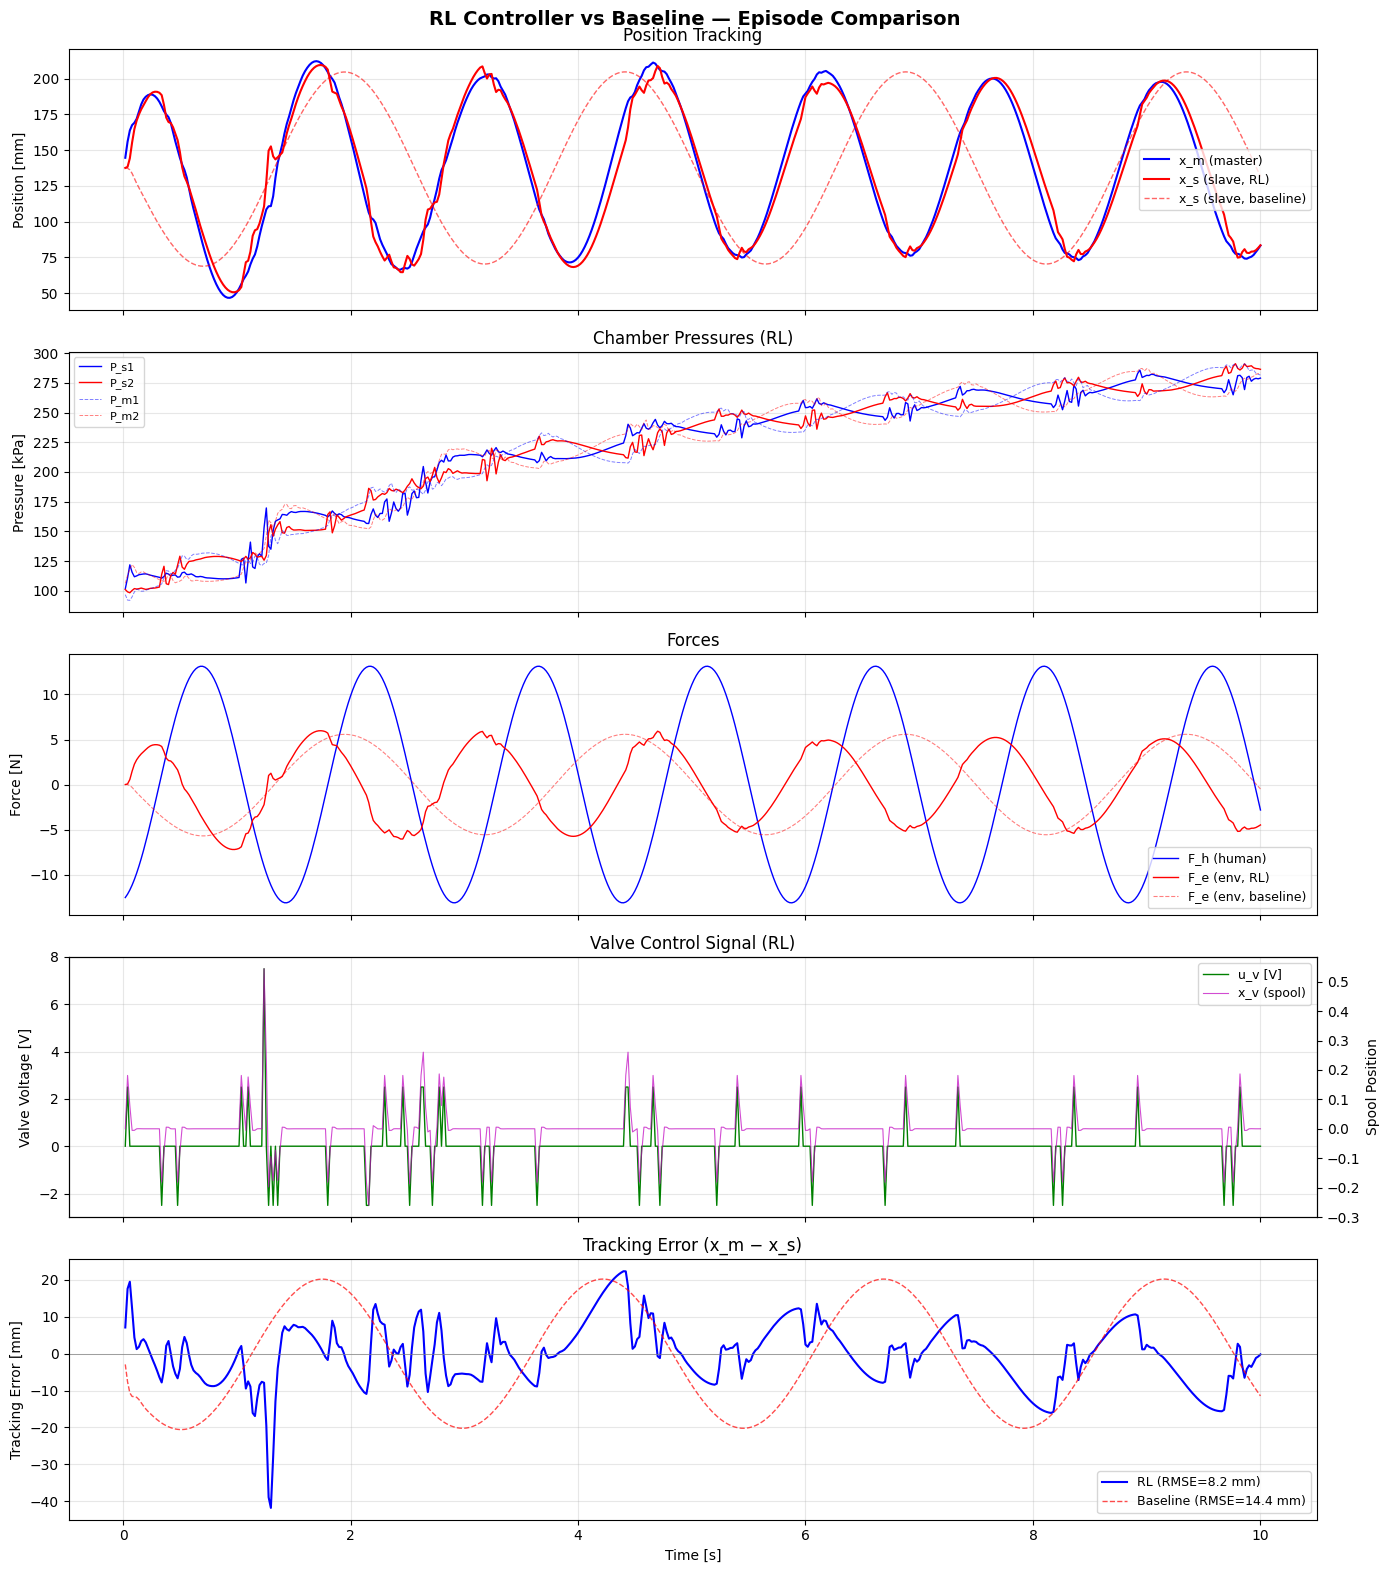

In [4]:
fig, axes = plt.subplots(5, 1, figsize=(14, 16), sharex=True)
fig.suptitle('RL Controller vs Baseline — Episode Comparison', fontsize=14, fontweight='bold')

t_rl = np.array(h_rl['time'])
t_bl = np.array(h_bl['time'])

# Position tracking
ax = axes[0]
ax.plot(t_rl, np.array(h_rl['x_m'])*1000, 'b-', lw=1.5, label='x_m (master)')
ax.plot(t_rl, np.array(h_rl['x_s'])*1000, 'r-', lw=1.5, label='x_s (slave, RL)')
ax.plot(t_bl, np.array(h_bl['x_s'])*1000, 'r--', lw=1, alpha=0.6, label='x_s (slave, baseline)')
ax.set_ylabel('Position [mm]'); ax.set_title('Position Tracking')
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

# Pressures
ax = axes[1]
ax.plot(t_rl, np.array(h_rl['P_s1'])/1000, 'b-', lw=1, label='P_s1')
ax.plot(t_rl, np.array(h_rl['P_s2'])/1000, 'r-', lw=1, label='P_s2')
ax.plot(t_rl, np.array(h_rl['P_m1'])/1000, 'b--', lw=0.7, alpha=0.5, label='P_m1')
ax.plot(t_rl, np.array(h_rl['P_m2'])/1000, 'r--', lw=0.7, alpha=0.5, label='P_m2')
ax.set_ylabel('Pressure [kPa]'); ax.set_title('Chamber Pressures (RL)')
ax.legend(fontsize=8); ax.grid(True, alpha=0.3)

# Forces
ax = axes[2]
ax.plot(t_rl, h_rl['F_h'], 'b-', lw=1, label='F_h (human)')
ax.plot(t_rl, h_rl['F_e'], 'r-', lw=1, label='F_e (env, RL)')
ax.plot(t_bl, h_bl['F_e'], 'r--', lw=0.8, alpha=0.5, label='F_e (env, baseline)')
ax.set_ylabel('Force [N]'); ax.set_title('Forces')
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

# Valve
ax = axes[3]
ax.plot(t_rl, h_rl['u_v'], 'g-', lw=1, label='u_v [V]')
ax2 = ax.twinx()
ax2.plot(t_rl, h_rl['x_v'], 'm-', lw=0.8, alpha=0.7, label='x_v (spool)')
ax.set_ylabel('Valve Voltage [V]'); ax2.set_ylabel('Spool Position')
ax.set_title('Valve Control Signal (RL)')
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1+lines2, labels1+labels2, fontsize=9); ax.grid(True, alpha=0.3)

# Tracking error
ax = axes[4]
ax.plot(t_rl, pe_rl, 'b-', lw=1.5, label=f'RL (RMSE={rmse_rl:.1f} mm)')
ax.plot(t_bl, pe_bl, 'r--', lw=1, alpha=0.7, label=f'Baseline (RMSE={rmse_bl:.1f} mm)')
ax.axhline(0, color='gray', lw=0.5)
ax.set_ylabel('Tracking Error [mm]'); ax.set_xlabel('Time [s]')
ax.set_title('Tracking Error (x_m − x_s)')
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/plots/episode_comparison.png', dpi=150, bbox_inches='tight')
plt.show()